In [6]:
# ライブラリの読み込み
using Plots
using Printf

In [7]:
struct Model{TI<:Integer, TF<:AbstractFloat}
    bet::TF
    kap::TF
    rstar::TF
    N::TF
    gam::TF
    phi::TF
    gy::TF
    sig::TF
    dc::TF   
    dn::TF   
    tol::TF
    nrho::TI # p_{L}のグリッドの数(プロット用)
    ng::TI   
end

In [8]:
function cer_nl_v1(gL,m,rho,zlbflag)
    """
    ---------------------------------------
    === 時間反復法によってモデルを解く関数 ===
    ---------------------------------------
    <input>
    ・gL: 状態Lでの政府支出
    ・m: パラメータを含むコンストラクタ
    ・rho: 状態Lの慣性(※異なるrhoについて財政乗数を計算したいからコンストラクタの外で定義している)
    ・zlbflag: ゼロ金利制約があるケース(=1) / ゼロ金利制約がないケース(=0)
    <output>
    ・yL: 状態Lでの産出量
    """
    @printf "gL = %1.4f\n" gL

    # STEP 1(a): グリッド生成
    pH = 0.0;
    pL = rho;
    sH = m.rstar;
    sL = -1.5; # 状態Lの時は、ZLBに直面するという仮定を置いているので財政乗数には影響を与えない。
    Gg = [0.0;gL];
    Pg = [1-pH pH; 1-pL pL];
    Gs = [sH;sL]

    # STEP 1(b): 政策関数の初期値を当て推量
    # 適当な初期値
    lamvec0 = zeros(m.ng);
    pivec0 = zeros(m.ng);
    lamvec1 = similar(lamvec0);
    pivec1 = similar(pivec0);
    cvec = similar(lamvec0);
    nvec = similar(lamvec0);
    rvec = similar(lamvec0);

    # STEP 4: 政策関数を繰り返し計算
    diff = 1e+4; # 政策関数の繰り返し誤差
    iter = 0; # ループ・カウンター

    while diff > m.tol

        for ig in 1:m.ng

            # ショックの値
            g0 = Gg[ig]

            # 古い政策関数から期待値(lame,pie)を計算
            lame = Pg[ig,:]' * lamvec0;
            pie = Pg[ig,:]' * pivec0;

            if zlbflag == 1 # ゼロ金利制約がある場合
                r0 = max(m.rstar+m.phi*pie,0.0);
            else # ゼロ金利制約がない場合
                r0 = m.rstar+m.phi*pie;
            end

            lam0 = lame + r0 - pie - Gs[ig];
            c0 = (lam0 - m.dn*m.gy*g0)/(m.dc + m.dn*(1-m.gy));
            n0 = (1-m.gy)*c0 + m.gy*g0;
            pi0 = m.bet*pie + m.kap*(c0 + m.N/(1-m.N)*n0);

            lamvec1[ig] = lam0;
            pivec1[ig] = pi0;
            cvec[ig] = c0;
            nvec[ig] = n0;
            rvec[ig] = r0;

        end

        diff_lam = maximum(abs.(lamvec1-lamvec0));
        diff_pi  = maximum(abs.(pivec1-pivec0));
        diff = maximum([diff_lam diff_pi]);    
        iter = iter + 1;

        # n000回目のイタレーションで結果を出力する
        #if (mod(iter,1000) == 0)
        #    println([iter, diff_lam, diff_pi]);
        #end

        lamvec0 = copy(lamvec1);
        pivec0 = copy(pivec1);

    end

    if rvec[2]>0
        println("ZLB is not binding at state L!!!")
    end

    yL = nvec[2];

    return yL
end

cer_nl_v1 (generic function with 1 method)

In [9]:
# カリブレーション
bet = 0.99;
kap = 0.03;
rstar = 100/bet-100;
N = 1/3;
gam = 0.29;
phi = 1.5;
gy = 0.2;
sig = 2.0;
dc = gam*(1-sig)-1;
dn = -(1-gam)*(1-sig)*N/(1-N)
tol = 1e-10;
nrho = 12;
ng = 2;

# 構造体にパラメータを格納 
m = Model(bet,kap,rstar,N,gam,phi,gy,sig,dc,dn,tol,nrho,ng);

# プロット用に異なるrhoのベクトルと結果を格納する配列を用意する
rhovec = collect(range(0.7,0.81,length=m.nrho));
mpvec0 = zeros(m.nrho) # ゼロ金利制約がないケースでの結果を格納
mpvec1 = zeros(m.nrho) # ゼロ金利制約があるケースでの結果を格納

for i in 1:m.nrho

    rho = rhovec[i]

    # ゼロ金利制約がないケース
    yL1 = cer_nl_v1(1.0,m,rho,0);
    yL0 = cer_nl_v1(0.0,m,rho,0);
    mpvec0[i] = (yL1-yL0)/m.gy;

    # ゼロ金利制約があるケース
    yL1 = cer_nl_v1(1.0,m,rho,1);
    yL0 = cer_nl_v1(0.0,m,rho,1);
    mpvec1[i] = (yL1-yL0)/m.gy;

end

gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000
gL = 1.0000
gL = 0.0000


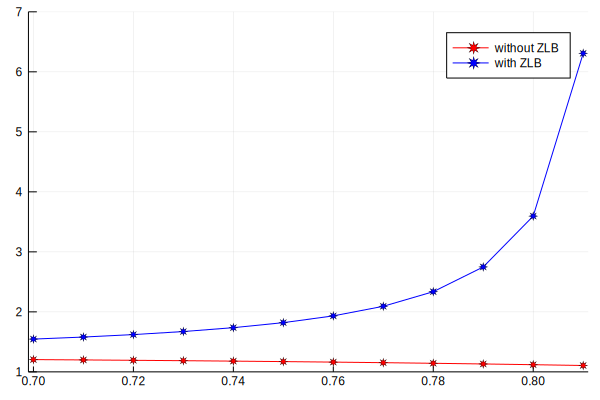

In [10]:
# プロット
plot(rhovec,mpvec0,color=:red,markershape=:star8,label="without ZLB",
legend=:topright,xlim=(rhovec[1]-0.001,rhovec[end]+0.001),ylim=(1,7))
plot!(rhovec,mpvec1,color=:blue,markershape=:star8,label="with ZLB")